## VARIATIONAL QUANTUM CLASSIFIER WITH QISKIT ##

The variational quantum classifier (VQC) is an hybrid quantum-classical classifier. The main idea is to use a parametrized quantum circuit (ansatz) iteratively with better and better parameters.

In more details:

We prepare our initial state with a feature map to encode classical data in the initial quantum state. Then we build a quantum circuit that applies some different rotations of angles $\theta_1, \cdots, \theta_l $ and other gates. Finally we collapse each qubit's wave function with a measurement. Here the classical part begins: we choose a loss function that takes the physical final state as an argument and a classical algorithm to minimize the loss function. Then we use the new parameters values to apply different rotations in the quantum circuit. So we iterate until an acceptance criterion is met.

In [1]:
#!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

#------------------------------------------
# To do the data preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

#------------------------------------------
# To confront the performance of quantum models with classical models
from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#------------------------------------------
# To assess the models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

#------------------------------------------
# To encode classical data into "quantum data" and to build vqc models
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes, NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.algorithms.classifiers import VQC  

#------------------------------------------
# To import the optimizers
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP

#------------------------------------------
# To simulate the ideal case
from qiskit.primitives import Sampler

#---------------------------------------------
# To simulate the noisy case
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeVigo
from qiskit.primitives import BackendSampler

#---------------------------------------------
import warnings
warnings.filterwarnings('ignore')

/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_95831/3512586508.py:32: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP


In [3]:
np.random.seed(42)

In [4]:
file_path = "dataset/dataset.csv"     # In the git hub repository, the dataset is in the dataset folder: https://github.com/EdoardoZappia/Fraud-Detection-with-QML/blob/main/dataset/dataset.csv

In [5]:
try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()

Dataset imported successfully.


We use the results of the data exploration and analysis, so we select 4 features

In [6]:
df.drop(columns=['step'], inplace=True)
df.drop(columns=['zipcodeOri'], inplace=True)
df.drop(columns=['zipMerchant'], inplace=True)
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

print(df.head())

   age gender             category  amount  fraud
0  '4'    'M'  'es_transportation'    4.55      0
1  '2'    'M'  'es_transportation'   39.68      0
2  '4'    'F'  'es_transportation'   26.89      0
3  '3'    'M'  'es_transportation'   17.25      0
4  '5'    'M'  'es_transportation'   35.72      0


To use the dataset with our models, we have to transform the categorical variables in numerical variables. In principal we could use one hot encoding technic but it would result in a much bigger dataset. For this reason we decide to use LabelEncoder.

In [7]:
encoder = LabelEncoder()

encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category'])
df['category'] = encoded_category

print(df.head())

   age  gender  category  amount  fraud
0    4       2        12    4.55      0
1    2       2        12   39.68      0
2    4       1        12   26.89      0
3    3       2        12   17.25      0
4    5       2        12   35.72      0


The original dataset is extremely unbalanced. We balance it with undersampling. Unfortunately Qiskit can be really slow for some tasks, so we decide to cut our dataset in only 100 fraud samples and 100 non-fraud samples.

In [8]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Check class distribution
print("Class distribution before undersampling:")
print(y.value_counts())

#---------------------------------------------------------------------------
# To have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 100, 1: 100}
#---------------------------------------------------------------------------

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution before undersampling:
fraud
0    587443
1      7200
Name: count, dtype: int64
Class distribution after undersampling:
fraud
0    100
1    100
Name: count, dtype: int64


In [9]:
X_resampled = MinMaxScaler().fit_transform(X_resampled)    # To have values between 0 and 1

Train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


In [11]:
# vqc.fit wants numpy ndarray as input
y_train_np = y_train.values
y_test_np = y_test.values

# QUANTUM FEATURE MAP:

Quantum feature maps are used to transform classical data into a quantum state that can be processed by a quantum computer. In a quantum feature map, the input data is transformed using a quantum gates operation to produce a new quantum state vector that contains higher-order correlations between the original data points 
$$\ket{\Psi(\vec{x})} = V_{\Phi(\vec{x})} \ket{0}^{\otimes N} $$
The quantum feature maps are able to efficiently generate complex transformation that are computationally hard to construct using classical method. Moreover, the base quantum circuit operation can also be repeated multiple times to construct more complex feature maps.

# Pauli feature map

Pauli feature map is a class of feature maps, in general it transforms input data with $N$ features $\vec{x}\in \mathbb{R}^N$ into quantum information in $N$ qubits $\ket{\Psi(\vec{x})}$. It can be described as unitary operator below:
$$V_{\Phi(\vec{x})} = U_{\Phi(\vec{x})} H^{\otimes N}\dots  U_{\Phi(\vec{x})} H^{\otimes N}$$
$U_{\Phi(\vec{x})} H^{\otimes N}$ represents the Pauli expansion matrix:
$$U_{\Phi(\vec{x})} = e^{i\sum_{S\subseteq I}\alpha \psi_{S}(\vec{x})\prod_{j\in S}P_j}$$
where $I$ is the set of qubit indices describing the connections in the feature map and $\psi_{S}(\vec{x})$ is the data mapping function.
$$\psi_{S}(\vec{x}) =  \begin{cases} x_j \quad\quad & \text{if } S=\{x_j\} \\ \prod_{j\in S}(\pi - x_j) \quad\quad & \text{if } |S|>1 \end{cases} $$
$P_j \in \{I, X, Y, Z\}$ represents the Pauli matrices and $\alpha$ is a variable to adjust the magnitude of Pauli rotation gates.
In the PauliFeatureMap class in Qiskit Python package we can specify the number of repetitions of the feature map to have more accurate representation; the entanglement type to represent the entanglement structure among qubits (linear, reverse linear, circular, full).

# Z feature map

The Z feature map is a first-order Pauli-Z evolution circuit. It's a specialization of the Pauli feature map. Z feature map is particularly well-suited for specific application where quantum circuit without entanglement is desired beacuse of the absence of entangling gates.

# ZZ feature map

The ZZ feature map is a second-order Pauli-Z evolution circuit. It is only a special case of Pauli feature maps with Pauli sequence $[Z, ZZ]$. The rotation blocks apply single-qubit rotations based on the classical data, parametrised by angles determined by a $\psi$. In our case, with four features we have $\psi(x,y,z,w) = (\pi-x)(\pi-y)(\pi-z)(\pi-w)$.

We try different feature map to encode our data:

- PauliFeatureMap
- ZFeatureMap
- ZZFeatureMap

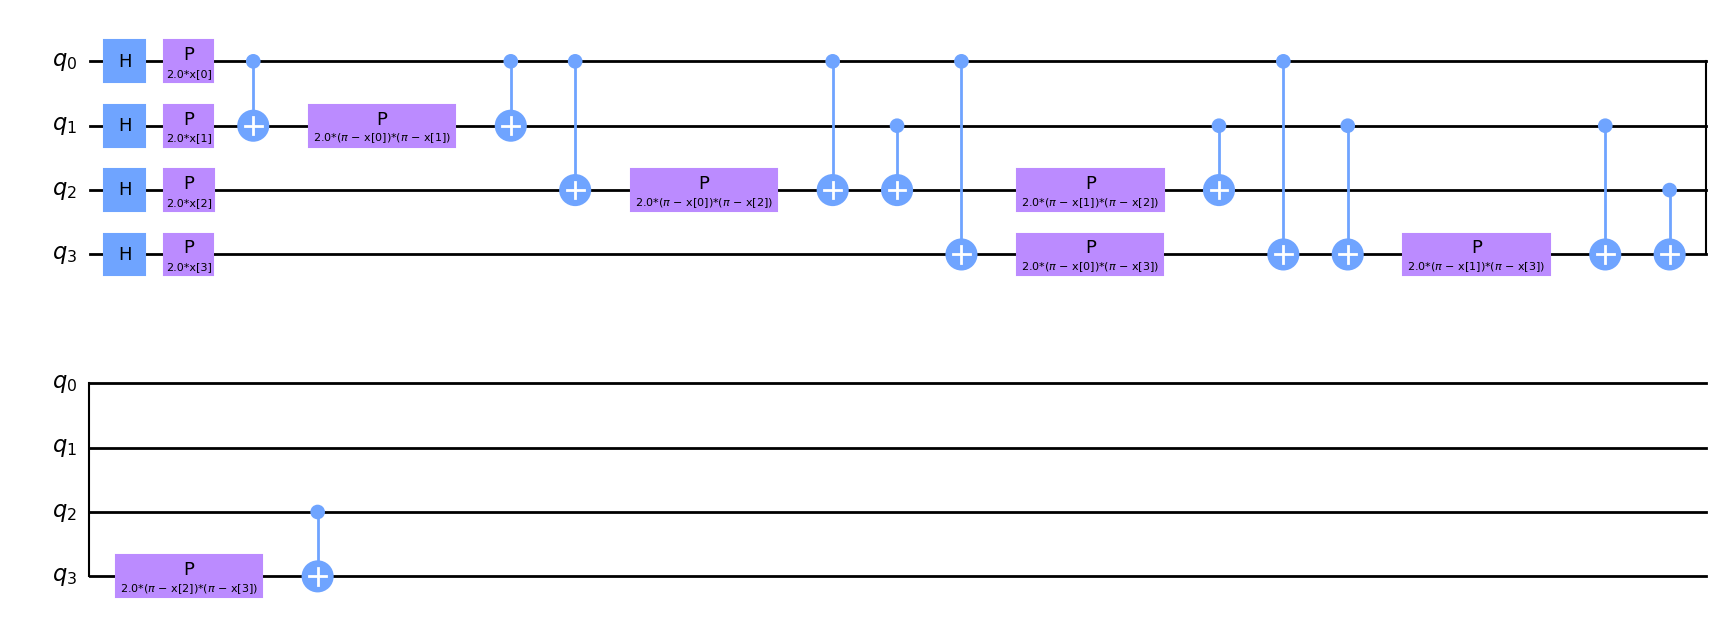

In [12]:
ZZ = ZZFeatureMap(feature_dimension=4, reps=1)   # feature_dimension = num_features       
ZZ.decompose().draw(output='mpl')

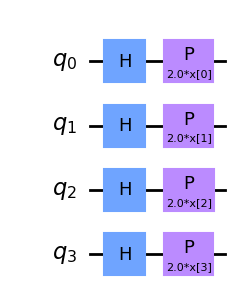

In [13]:
Z = ZFeatureMap(feature_dimension=4, reps=1)   # feature_dimension = num_features
Z.decompose().draw(output='mpl')

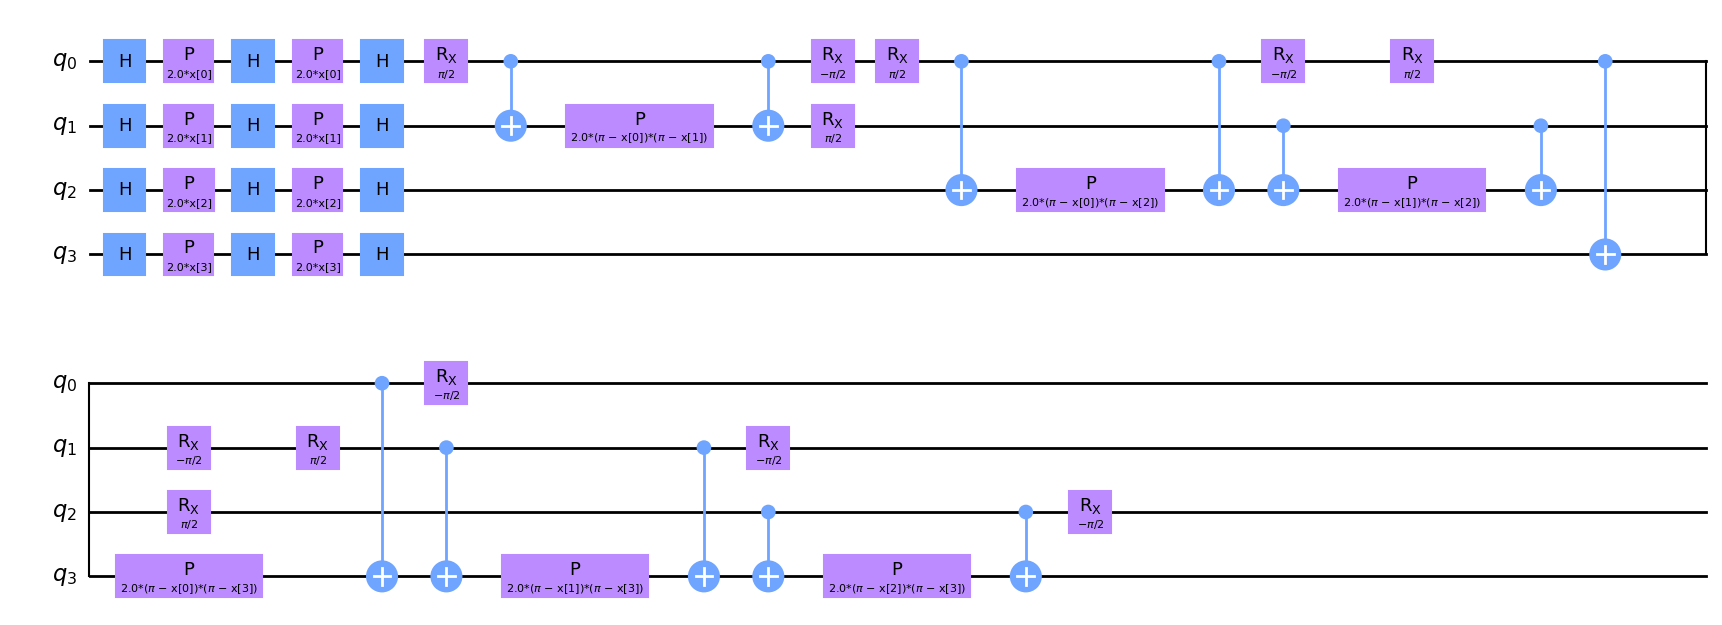

In [14]:
P = PauliFeatureMap(feature_dimension=4, reps=1, paulis=['Z','X','ZY'])   # feature_dimension = num_features
P.decompose().draw(output='mpl')

ZZ2 is the same as ZZ but with 2 repetitions, it could impact the performance, specially in the simulation with noise. In the case of depth 2, the feature map has more CNOT gates so if it's run in a real quantum hardware (and in a noisy simulator) it could cause an error propagation.

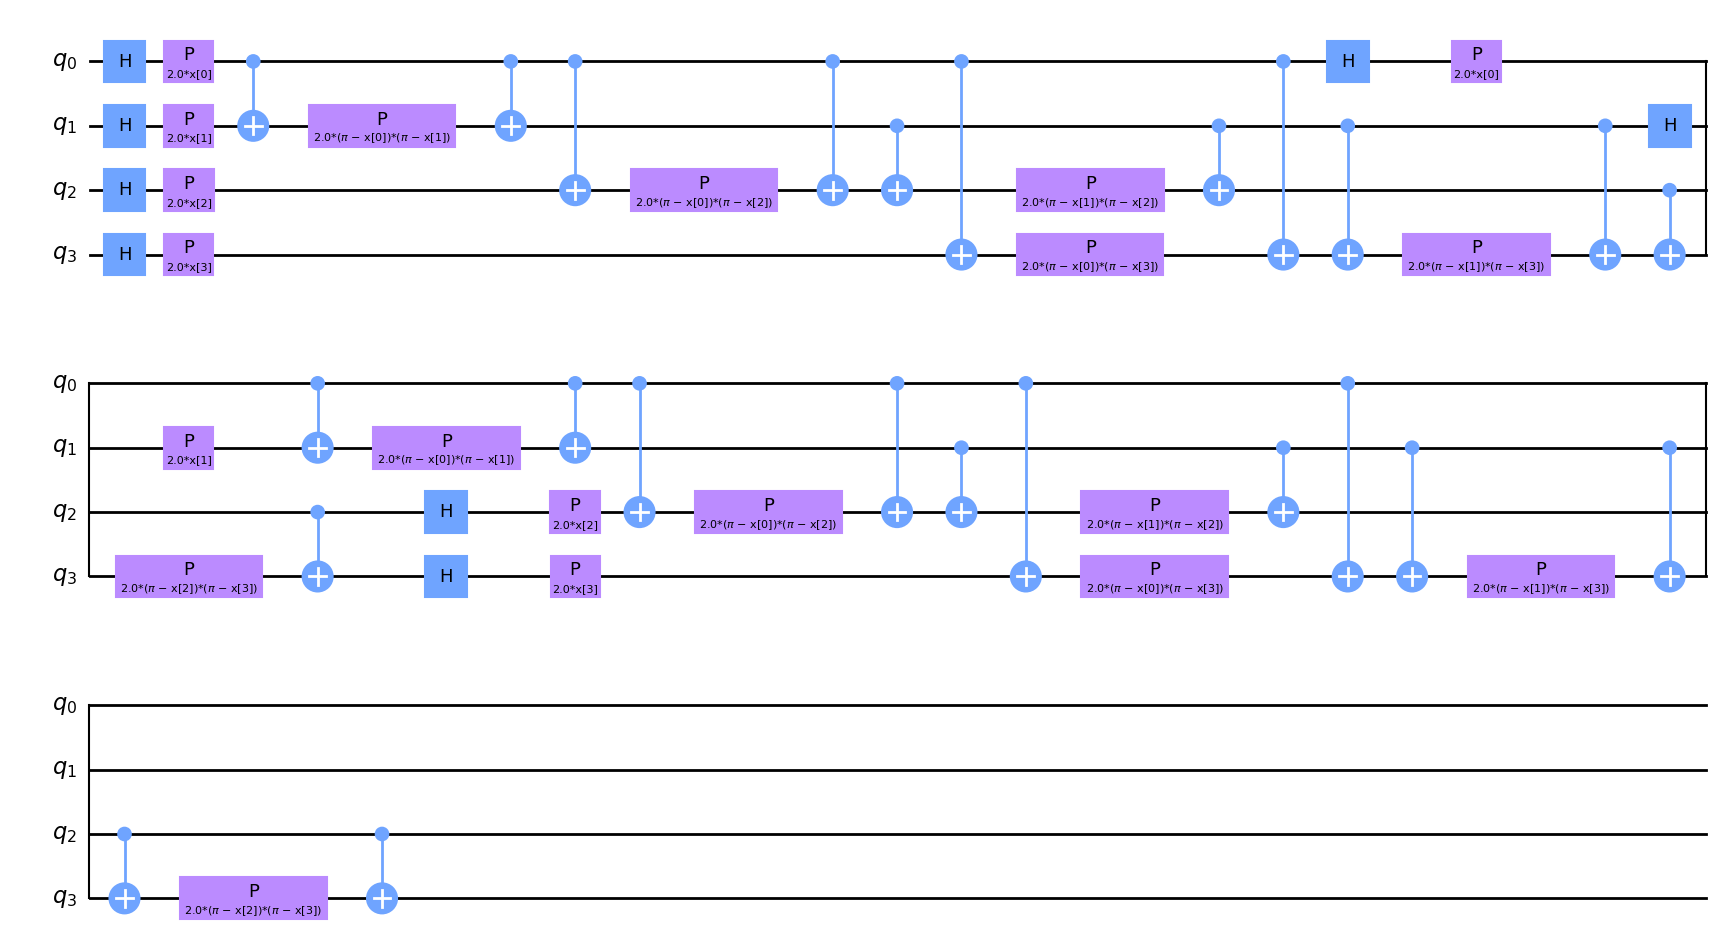

In [15]:
ZZ2 = ZZFeatureMap(feature_dimension=4, reps=2)   # feature_dimension = num_features       
ZZ2.decompose().draw(output='mpl')

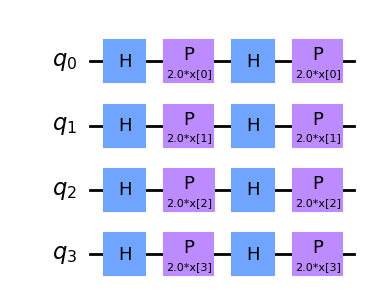

In [16]:
Z2 = ZFeatureMap(feature_dimension=4, reps=2)   # feature_dimension = num_features
Z2.decompose().draw(output='mpl')

Ansatz

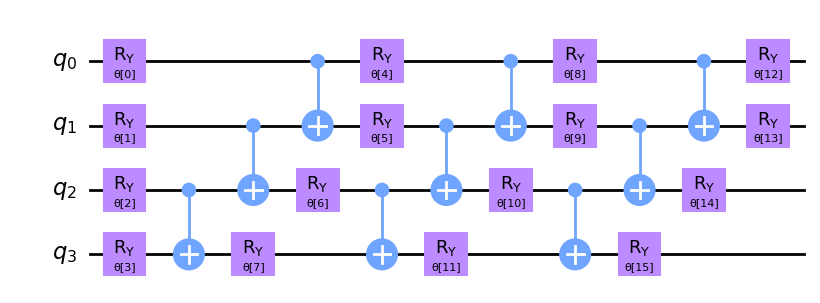

In [17]:
pqc = RealAmplitudes(num_qubits=4, reps=3)  # num_qubits = num_features
pqc.decompose().draw(output='mpl')

We try a custom ansatz to confront the results with the most used one. NLocal is built in blocks: rotations blocks and entanglement blocks. In our case is built with RY and RZ rotations, CNOT gates and the blocks are repeated 2 times.

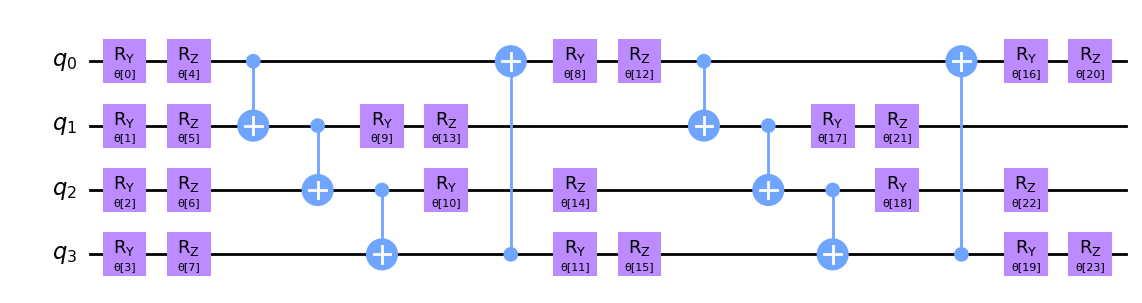

In [18]:
num_qubits = 4

parameters_ry = [Parameter(f'phi_{i}') for i in range(num_qubits)]
parameters_rz = [Parameter(f'theta_{i}') for i in range(num_qubits)]

qc = QuantumCircuit(num_qubits)
for q, parameter in enumerate(parameters_ry):
    qc.ry(parameter, q)
for q, parameter in enumerate(parameters_rz):
    qc.rz(parameter, q)

ent = QuantumCircuit(num_qubits)
for q in range(num_qubits):
    ent.cx(q, (q + 1) % 4)

nlocal = NLocal(num_qubits=num_qubits, rotation_blocks=[qc],entanglement_blocks= ent, reps=2, insert_barriers=False)    
nlocal.decompose().draw(output='mpl')

There are three types of Optimizers:

- COBYLA (Constrained Optimization By Linear Approximation optimizer.)
- SPSA (Simultaneous Perturbation Stochastic Approximation optimizer.)
- SLSQP (Sequential Least Squares Programming optimize)

- COBYLA

COBYLA (Constrained Optimization BY Linear Approximation) is a gradient-free optimization algorithm that uses a linear approximation of the function in the neighborhood of the current point to determine the next point to evaluate. The algorithm is based on the idea of "trust regions," which means that the algorithm only considers changes to the variables that are within a certain "trust region" around the current point. It is particularly useful when the objective function is expensive to evaluate or is non-differentiable. It is also well-suited for problems with constraints, as it can handle both equality and inequality constraints.
The COBYLA algorithm has two important parameters: rhobeg and maxiter. rhobeg determines the size of the initial "trust region" around the starting point, and maxiter specifies the maximum number of iterations the algorithm can perform before terminating. In general, smaller values of rhobeg will lead to more accurate results, but may also increase the computational cost of the algorithm.

- SPSA

SPSA is a general method for minimizing differentiable multivariate functions. It is particularly useful for functions for which evaluating the gradient is not possible, or too resource intensive. SPSA provides a stochastic method for approximating the gradient of the cost function. To accomplish this, the cost function is evaluated twice using perturbed parameter vectors: every component of the original parameter vector is simultaneously shifted with a randomly generated value. This is in contrast to finite-differences methods where for each evaluation only one component of the parameter vector is shifted at a time.

- SLSQP

SLSQP optimizer is a sequential least squares programming algorithm which uses the Han-Powell quasi-Newton method with a BFGS update of the B-matrix and an L1-test function in the step-length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver.

In [19]:
optimizer = COBYLA(maxiter=175)     # maxiter is the maximum number of iterations   

sampler = Sampler() # We use a simulator. We create an instance of the Sampler primitive.
# We simulate with the statevector simulator so we simulate ideal quantum state evolution.

initial_point=np.random.random(pqc.num_parameters)  # Initialization of weights

objective_func_vals = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []}    # Dictionary to save the loss function values

def callback(feature_map_name, obj_func_eval):
    objective_func_vals[feature_map_name].append(obj_func_eval)

def plot_objective_function_values():
    clear_output(wait=True)
    
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    for feature_map_name, obj_func_vals in objective_func_vals.items():
        plt.plot(range(len(obj_func_vals)), obj_func_vals, label=feature_map_name)
    plt.legend()
    plt.show()

# In Qiskit, the default loss function is cross entropy

vqc_Z = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z', obj_func_eval),
)

vqc_ZZ = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ', obj_func_eval),
)

vqc_P = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('P', obj_func_eval),
)

vqc_Z2 = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z2', obj_func_eval),
)

vqc_ZZ2 = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ2', obj_func_eval),
)

We repeate the building cell using the custom ansatz

In [20]:
objective_func_vals_nloc = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []}

initial_point_nloc=np.random.random(nlocal.num_parameters)

def callback_nloc(feature_map_name, obj_func_eval):
    # Append objective function value to the corresponding list based on the feature map name
    objective_func_vals_nloc[feature_map_name].append(obj_func_eval)

def plot_objective_function_values_nloc():
    clear_output(wait=True)
    
    # Plot all loss function values
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    for feature_map_name, obj_func_vals in objective_func_vals_nloc.items():
        plt.plot(range(len(obj_func_vals)), obj_func_vals, label=feature_map_name)
    plt.legend()
    plt.show()

vqc_Z_nloc = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z', obj_func_eval),
)

vqc_ZZ_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ', obj_func_eval),
)

vqc_P_nloc = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('P', obj_func_eval),
)

vqc_Z2_nloc = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z2', obj_func_eval),
)

vqc_ZZ2_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ2', obj_func_eval),
)


In [21]:
%%time
vqc_Z.fit(X_train, y_train_np)

CPU times: user 4min 55s, sys: 5.3 s, total: 5min
Wall time: 6min 4s


In [22]:
%%time
vqc_ZZ.fit(X_train, y_train_np)

CPU times: user 7min 39s, sys: 8.27 s, total: 7min 47s
Wall time: 9min 21s


In [23]:
%%time
vqc_P.fit(X_train, y_train_np)

CPU times: user 8min 54s, sys: 8.95 s, total: 9min 3s
Wall time: 10min 54s


In [24]:
%%time
vqc_Z2.fit(X_train, y_train_np)

CPU times: user 5min 38s, sys: 7.59 s, total: 5min 46s
Wall time: 7min 8s


In [25]:
%%time
vqc_ZZ2.fit(X_train, y_train_np)

CPU times: user 10min 39s, sys: 16.8 s, total: 10min 55s
Wall time: 13min 54s


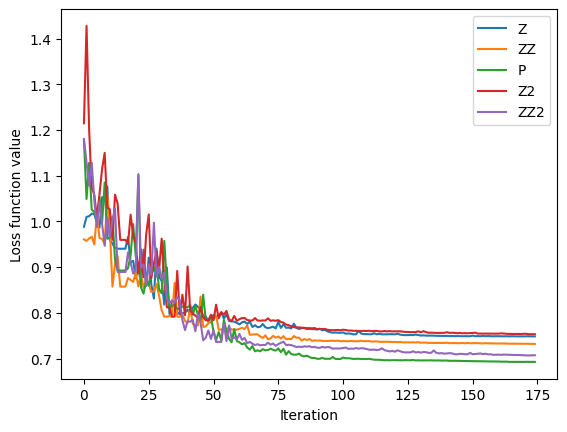

In [26]:
plot_objective_function_values()

In [27]:
%%time
vqc_Z_nloc.fit(X_train, y_train_np)

CPU times: user 6min 30s, sys: 8.01 s, total: 6min 38s
Wall time: 8min 11s


In [28]:
%%time
vqc_ZZ_nloc.fit(X_train, y_train_np)

CPU times: user 9min 24s, sys: 12.3 s, total: 9min 36s
Wall time: 11min 56s


In [29]:
%%time
vqc_P_nloc.fit(X_train, y_train_np)

CPU times: user 11min 14s, sys: 13.1 s, total: 11min 27s
Wall time: 14min 10s


In [30]:
%%time
vqc_Z2_nloc.fit(X_train, y_train_np)

CPU times: user 7min 35s, sys: 9.6 s, total: 7min 45s
Wall time: 9min 29s


In [31]:
%%time
vqc_ZZ2_nloc.fit(X_train, y_train_np)

CPU times: user 11min 31s, sys: 13 s, total: 11min 44s
Wall time: 14min 23s


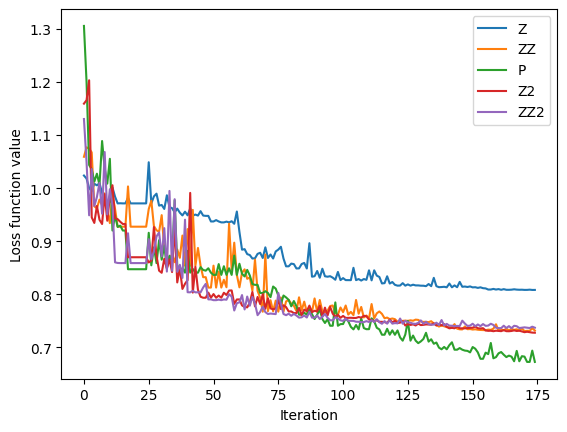

In [32]:
plot_objective_function_values_nloc()

vqc.score in classification problems should be mean accuracy

In [33]:
Z_score_RA = vqc_Z.score(X_test, y_test_np)
ZZ_score_RA = vqc_ZZ.score(X_test, y_test_np)
P_score_RA = vqc_P.score(X_test, y_test_np)
Z2_score_RA = vqc_Z2.score(X_test, y_test_np)
ZZ2_score_RA = vqc_ZZ2.score(X_test, y_test_np)

In [34]:
print("VQC with Z feature map and RealAmplitude as ansatz score:", Z_score_RA)
print("VQC with ZZ feature map and RealAmplitude as ansatz score:", ZZ_score_RA)
print("VQC with Pauli feature map and RealAmplitude as ansatz score:", P_score_RA)
print("VQC with Z2 feature map and RealAmplitude as ansatz score:", Z2_score_RA)
print("VQC with ZZ2 feature map and RealAmplitude as ansatz score:", ZZ2_score_RA)

VQC with Z feature map and RealAmplitude as ansatz score: 0.85
VQC with ZZ feature map and RealAmplitude as ansatz score: 0.8333333333333334
VQC with Pauli feature map and RealAmplitude as ansatz score: 0.7666666666666667
VQC with Z2 feature map and RealAmplitude as ansatz score: 0.8333333333333334
VQC with ZZ2 feature map and RealAmplitude as ansatz score: 0.75


In [35]:
Z_score_NL = vqc_Z_nloc.score(X_test, y_test_np)
ZZ_score_NL = vqc_ZZ_nloc.score(X_test, y_test_np)
P_score_NL = vqc_P_nloc.score(X_test, y_test_np)
Z2_score_NL = vqc_Z2_nloc.score(X_test, y_test_np)
ZZ2_score_NL = vqc_ZZ2_nloc.score(X_test, y_test_np)

In [36]:
print("VQC with Z feature map and NLocal as ansatz score:", Z_score_NL)
print("VQC with ZZ feature map and NLocal as ansatz score:", ZZ_score_NL)
print("VQC with Pauli feature map and NLocal as ansatz score:", P_score_NL)
print("VQC with Z2 feature map and NLocal as ansatz score:", Z2_score_NL)
print("VQC with ZZ2 feature map and NLocal as ansatz score:", ZZ2_score_NL)

VQC with Z feature map and NLocal as ansatz score: 0.7666666666666667
VQC with ZZ feature map and NLocal as ansatz score: 0.85
VQC with Pauli feature map and NLocal as ansatz score: 0.8
VQC with Z2 feature map and NLocal as ansatz score: 0.8
VQC with ZZ2 feature map and NLocal as ansatz score: 0.8


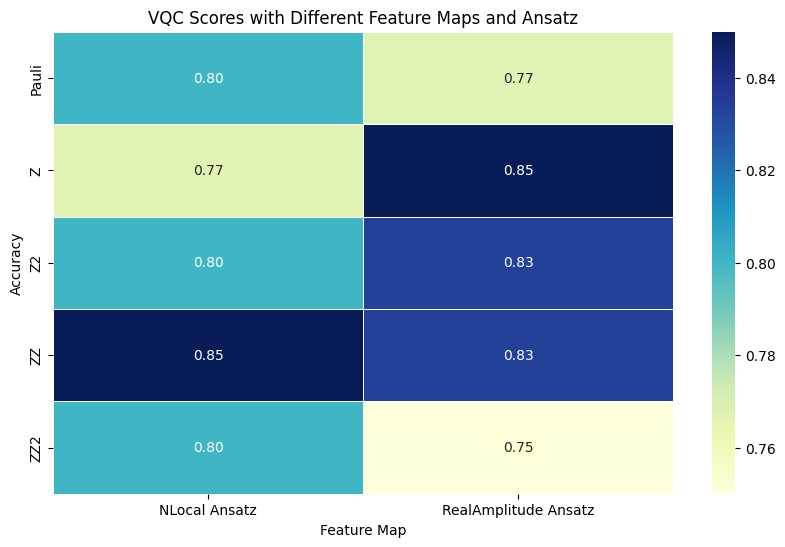

In [37]:
data = {
    "Feature Map": ["Z", "ZZ", "Pauli", "Z2", "ZZ2"],
    "RealAmplitude Ansatz": [
        Z_score_RA,
        ZZ_score_RA,
        P_score_RA,
        Z2_score_RA,
        ZZ2_score_RA
    ],
    "NLocal Ansatz": [
        Z_score_NL,
        ZZ_score_NL,
        P_score_NL,
        Z2_score_NL,
        ZZ2_score_NL
    ]
}

# Convert data to a pivot table format suitable for heatmap
pivot_table = pd.pivot_table(pd.DataFrame(data), values=['RealAmplitude Ansatz', 'NLocal Ansatz'], index='Feature Map')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title('VQC Scores with Different Feature Maps and Ansatz')
plt.xlabel('Feature Map')
plt.ylabel('Accuracy')
plt.show()

In [38]:
def evaluate_with_feature_map(vqc, X_train, y_train, X_test, y_test, feature_map_name):     # Function to evaluate the VQC model with different indexes
    # Perform predictions on training and test sets
    y_train_pred = vqc.predict(X_train)
    y_test_pred = vqc.predict(X_test)
    
    # Print classification report and confusion matrix for training set
    print(f"Classification Report for {feature_map_name} Feature Map (Train Set):\n")
    print(classification_report(y_train_np, y_train_pred))
    print("Confusion Matrix for Train Set:")
    print(confusion_matrix(y_train_np, y_train_pred))
    print("\n")
    
    # Print classification report and confusion matrix for test set
    print(f"Classification Report for {feature_map_name} Feature Map (Test Set):\n")
    print(classification_report(y_test_np, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test_np, y_test_pred))

    # Print ROC AUC score for test set
    print(f"ROC AUC Score for {feature_map_name} Feature Map (Test Set):")
    print(round(roc_auc_score(y_test_np, y_test_pred), 4))
    print(70*'=')

In [39]:
vqc_models = {'Z': vqc_Z, 'ZZ': vqc_ZZ, 'P': vqc_P, 'Z2': vqc_Z2, 'ZZ2': vqc_ZZ2}

for feature_map_name, vqc_model in vqc_models.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        71
           1       0.88      0.81      0.84        69

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140

Confusion Matrix for Train Set:
[[63  8]
 [13 56]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.89      0.81      0.85        31

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix for Test Set:
[[26  3]
 [ 6 25]]
ROC AUC Score for Z Feature Map (Test Set):
0.8515
Evaluating performance for ZZ Feature Map:

In [40]:
vqc_models_nloc = {'Z': vqc_Z_nloc, 'ZZ': vqc_ZZ_nloc, 'P': vqc_P_nloc, 'Z2': vqc_Z2_nloc, 'ZZ2': vqc_ZZ2_nloc}

for feature_map_name, vqc_model in vqc_models_nloc.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:



Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.81      0.82      0.81        71
           1       0.81      0.80      0.80        69

    accuracy                           0.81       140
   macro avg       0.81      0.81      0.81       140
weighted avg       0.81      0.81      0.81       140

Confusion Matrix for Train Set:
[[58 13]
 [14 55]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.73      0.83      0.77        29
           1       0.81      0.71      0.76        31

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60

Confusion Matrix for Test Set:
[[24  5]
 [ 9 22]]
ROC AUC Score for Z Feature Map (Test Set):
0.7686
Evaluating performance for ZZ Feature Map:

Classification Report for ZZ Feature Map 

We tried also SPSA and SLSQP but we found similar results as with the COBYLA optimizer. The main difference is the execution time: COBYLA is the fastest one, SPSA is slower than COBYLA but is still runnable, and SLSQP is really slow.

# Conclusions on the noiseless case:

- RealAmplitudes Ansatz:

Looking at the loss function graph and the accuracy heatmap, it seems that the model that uses the PauliFeaturemap and the ZZ2 overfits the data.

Looking at accuracies of the models that use the Z and the ZZ2, it seems that our dataset doesn't require a lot of entanglement to be encoded in the quantum circuit.

The values reached by the loss functions are nearly the same. Also the accuracies are pretty similar, with the exception of the Pauli and ZZ2 ones.

- NLocal Ansatz:

Again the model that uses the PauliFeaturemap seems to overfit a bit the data. In this case the loss functions reach different values but there is not a big gap between them.
The NLocal ansatz has almost double the parameters of the RealAmplitudes one. So the model would require more iterations to optimize the parameters. The difference in performance is expalined by the fact that we fix the same number of iterations for both the models.

Now we try different classical machine learning models

In [41]:
%%time

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train_np)                         
    
    y_train_pred = ML_model.predict(X_train)       
    y_test_pred = ML_model.predict(X_test)
    
    
    print(classification_report(y_train_np, y_train_pred))
    print("Confusion Matrix for Train Set:")    
    print(confusion_matrix(y_train_np, y_train_pred))

    print(classification_report(y_test_np, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test_np, y_test_pred))
    print(f"ROC AUC Score (Test Set):")
    print(round(roc_auc_score(y_test_np, y_test_pred),2))
    
    print(70*'=')
    
print(70*'=')
ML_model = linear_model.LogisticRegression()         
train_test(ML_model)


ML_model = MLPClassifier()                            
train_test(ML_model)


ML_model = svm.SVC() 
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)


                     LogisticRegression() 

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        71
           1       0.87      0.80      0.83        69

    accuracy                           0.84       140
   macro avg       0.85      0.84      0.84       140
weighted avg       0.85      0.84      0.84       140

Confusion Matrix for Train Set:
[[63  8]
 [14 55]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.89      0.81      0.85        31

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix for Test Set:
[[26  3]
 [ 6 25]]
ROC AUC Score (Test Set):
0.85
                     MLPClassifier() 

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        71
           1       0.8

The classical models outperform in accuracy and in time the quantum models tested. We are still in the beginning of QML (and in the NISQ era) so we think that with time and with the advancing of the technology, the quantum models could outperform the classical ones, as the theory says.

# NOISY CASE #

To simulate the noisy case, it's been used the FakeVigo backend. 

vigo_simulator contains an approximate noise model consisting of:

- Single-qubit gate errors consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.
- Two-qubit gate errors consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
- Single-qubit readout errors on the classical bit value obtained from measurements on individual qubits.

In [42]:
device_backend = FakeVigo()
sim_vigo = AerSimulator.from_backend(device_backend)

In [43]:
sim_vigo.shots = 1000
sim_vigo.optimization_level = 3

optimization_level:

------------------------------------------------------------------------------------------------------

0 

No optimization: typically used for hardware characterization or debugging

- Basis translation
- Layout (as specified)
- Routing (stochastic swaps)

------------------------------------------------------------------------------------------------------

1,2,3

Light optimization:

- Single-qubit gate optimization
- Two-qubit gate optimization
- Error suppression: dynamical decoupling

In current primitive versions, optimization levels 2 and 3 behave identically to level 1.

In [44]:
sampler = BackendSampler(backend=sim_vigo)

In [45]:
optimizer = COBYLA(maxiter=175) 

initial_point=np.random.random(pqc.num_parameters)

objective_func_vals = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []}

In [46]:
vqc_Z = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z', obj_func_eval),
)

vqc_ZZ = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ', obj_func_eval),
)

vqc_P = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('P', obj_func_eval),
)

vqc_Z2 = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z2', obj_func_eval),
)

vqc_ZZ2 = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ2', obj_func_eval),
)


In [47]:
initial_point_nloc=np.random.random(nlocal.num_parameters)

objective_func_vals_nloc = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []}

In [48]:
vqc_Z_nloc = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z', obj_func_eval),
)

vqc_ZZ_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ', obj_func_eval),
)

vqc_P_nloc = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('P', obj_func_eval),
)

vqc_Z2_nloc = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z2', obj_func_eval),
)

vqc_ZZ2_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ2', obj_func_eval),
)


In [49]:
%%time
vqc_Z.fit(X_train, y_train_np)

CPU times: user 5min 39s, sys: 1min 28s, total: 7min 7s
Wall time: 6min 34s


In [50]:
%%time
vqc_ZZ.fit(X_train, y_train_np)

CPU times: user 8min 39s, sys: 1min 24s, total: 10min 3s
Wall time: 10min 27s


In [51]:
%%time
vqc_P.fit(X_train, y_train_np)

CPU times: user 13min 11s, sys: 1min 33s, total: 14min 44s
Wall time: 16min 22s


In [52]:
%%time
vqc_Z2.fit(X_train, y_train_np)

CPU times: user 5min 48s, sys: 47.7 s, total: 6min 35s
Wall time: 6min 59s


In [53]:
%%time
vqc_ZZ2.fit(X_train, y_train_np)

CPU times: user 10min 30s, sys: 1min 19s, total: 11min 50s
Wall time: 12min 51s


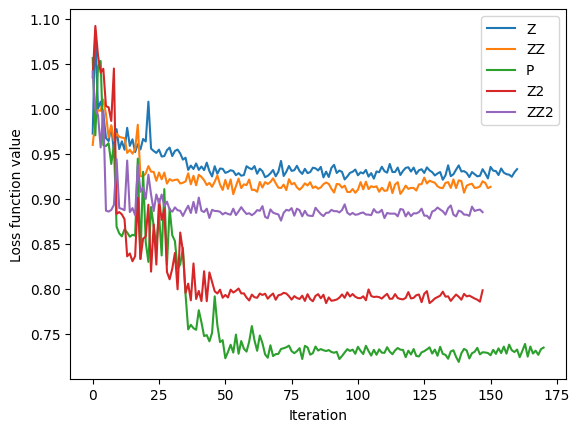

In [54]:
plot_objective_function_values()

In [55]:
%%time
vqc_Z_nloc.fit(X_train, y_train_np)

CPU times: user 7min 21s, sys: 1min 21s, total: 8min 42s
Wall time: 9min 40s


In [56]:
%%time
vqc_ZZ_nloc.fit(X_train, y_train_np)

CPU times: user 17min 37s, sys: 1min 34s, total: 19min 12s
Wall time: 23min 16s


In [57]:
%%time
vqc_P_nloc.fit(X_train, y_train_np)

CPU times: user 14min 5s, sys: 1min 37s, total: 15min 42s
Wall time: 17min 49s


In [58]:
%%time
vqc_Z2_nloc.fit(X_train, y_train_np)

CPU times: user 7min 13s, sys: 1min 32s, total: 8min 46s
Wall time: 8min 43s


In [59]:
%%time
vqc_ZZ2_nloc.fit(X_train, y_train_np)

CPU times: user 13min 49s, sys: 1min 32s, total: 15min 22s
Wall time: 17min 53s


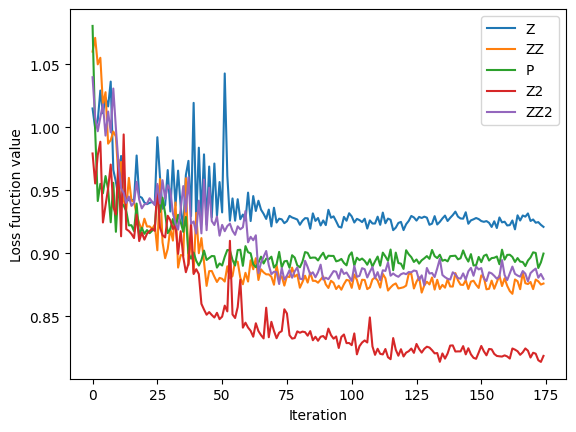

In [60]:
plot_objective_function_values_nloc()

In [61]:
Z_score_RA = vqc_Z.score(X_test, y_test_np)
ZZ_score_RA = vqc_ZZ.score(X_test, y_test_np)
P_score_RA = vqc_P.score(X_test, y_test_np)
Z2_score_RA = vqc_Z2.score(X_test, y_test_np)
ZZ2_score_RA = vqc_ZZ2.score(X_test, y_test_np)

In [62]:
print("VQC with Z feature map and RealAmplitude as ansatz score:", Z_score_RA)
print("VQC with ZZ feature map and RealAmplitude as ansatz score:", ZZ_score_RA)
print("VQC with Pauli feature map and RealAmplitude as ansatz score:", P_score_RA)
print("VQC with Z2 feature map and RealAmplitude as ansatz score:", Z2_score_RA)
print("VQC with ZZ2 feature map and RealAmplitude as ansatz score:", ZZ2_score_RA)

VQC with Z feature map and RealAmplitude as ansatz score: 0.7333333333333333
VQC with ZZ feature map and RealAmplitude as ansatz score: 0.6833333333333333
VQC with Pauli feature map and RealAmplitude as ansatz score: 0.8166666666666667
VQC with Z2 feature map and RealAmplitude as ansatz score: 0.8333333333333334
VQC with ZZ2 feature map and RealAmplitude as ansatz score: 0.8


In [63]:
Z_score_NL = vqc_Z_nloc.score(X_test, y_test_np)
ZZ_score_NL = vqc_ZZ_nloc.score(X_test, y_test_np)
P_score_NL = vqc_P_nloc.score(X_test, y_test_np)
Z2_score_NL = vqc_Z2_nloc.score(X_test, y_test_np)
ZZ2_score_NL = vqc_ZZ2_nloc.score(X_test, y_test_np)

In [64]:
print("VQC with Z feature map and NLocal as ansatz score:", Z_score_NL)
print("VQC with ZZ feature map and NLocal as ansatz score:", ZZ_score_NL)
print("VQC with Pauli feature map and NLocal as ansatz score:", P_score_NL)
print("VQC with Z2 feature map and NLocal as ansatz score:", Z2_score_NL)
print("VQC with ZZ2 feature map and NLocal as ansatz score:", ZZ2_score_NL)

VQC with Z feature map and NLocal as ansatz score: 0.7166666666666667
VQC with ZZ feature map and NLocal as ansatz score: 0.8166666666666667
VQC with Pauli feature map and NLocal as ansatz score: 0.6666666666666666
VQC with Z2 feature map and NLocal as ansatz score: 0.9
VQC with ZZ2 feature map and NLocal as ansatz score: 0.7333333333333333


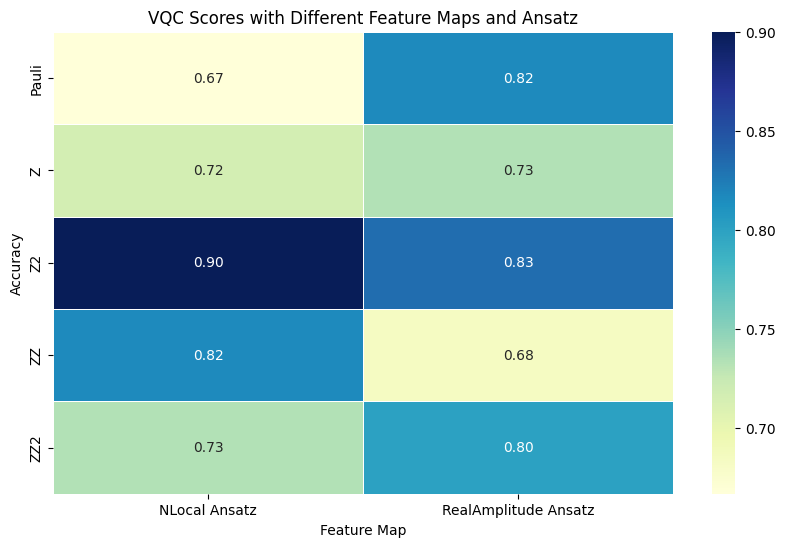

In [65]:
data = {
    "Feature Map": ["Z", "ZZ", "Pauli", "Z2", "ZZ2"],
    "RealAmplitude Ansatz": [
        Z_score_RA,
        ZZ_score_RA,
        P_score_RA,
        Z2_score_RA,
        ZZ2_score_RA
    ],
    "NLocal Ansatz": [
        Z_score_NL,
        ZZ_score_NL,
        P_score_NL,
        Z2_score_NL,
        ZZ2_score_NL
    ]
}

# Convert data to a pivot table format suitable for heatmap
pivot_table = pd.pivot_table(pd.DataFrame(data), values=['RealAmplitude Ansatz', 'NLocal Ansatz'], index='Feature Map')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title('VQC Scores with Different Feature Maps and Ansatz')
plt.xlabel('Feature Map')
plt.ylabel('Accuracy')
plt.show()

In [66]:
vqc_models = {'Z': vqc_Z, 'ZZ': vqc_ZZ, 'P': vqc_P, 'Z2': vqc_Z2, 'ZZ2': vqc_ZZ2}

for feature_map_name, vqc_model in vqc_models.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        71
           1       0.75      0.78      0.77        69

    accuracy                           0.76       140
   macro avg       0.76      0.76      0.76       140
weighted avg       0.76      0.76      0.76       140

Confusion Matrix for Train Set:
[[53 18]
 [15 54]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        31

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

Confusion Matrix for Test Set:
[[24  5]
 [ 5 26]]
ROC AUC Score for Z Feature Map (Test Set):
0.8331
Evaluating performance for ZZ Feature Map:

In [67]:
vqc_models_nloc = {'Z': vqc_Z_nloc, 'ZZ': vqc_ZZ_nloc, 'P': vqc_P_nloc, 'Z2': vqc_Z2_nloc, 'ZZ2': vqc_ZZ2_nloc}

for feature_map_name, vqc_model in vqc_models_nloc.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.63      0.90      0.74        71
           1       0.82      0.46      0.59        69

    accuracy                           0.69       140
   macro avg       0.73      0.68      0.67       140
weighted avg       0.73      0.69      0.67       140

Confusion Matrix for Train Set:
[[64  7]
 [37 32]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.65      0.97      0.78        29
           1       0.94      0.52      0.67        31

    accuracy                           0.73        60
   macro avg       0.80      0.74      0.72        60
weighted avg       0.80      0.73      0.72        60

Confusion Matrix for Test Set:
[[28  1]
 [15 16]]
ROC AUC Score for Z Feature Map (Test Set):
0.7408
Evaluating performance for ZZ Feature Map:

# Conclusions on the noisy case:

We would expect that the feature maps with more CNOT like ZZ2 would perform worse than more simple feature maps. In fact, in the noisy simulation, the number of CNOT could impact results propagating the error. With both the Ansatz there is a gap between the loss functions.

- RealAmplitudes Ansatz:

Looking at the loss function graph and the accuracy heatmap, it seems that there is not overfitting.

The values reached by the loss functions are a bit different and the model doesn't reach the maximum number of iterations. Confronting the performances of the model using ZFeaturemap with depth 2 and depth 1 and using ZZFeaturemap with depth 2 and depth 1, it seems that our dataset doesn't require a lot of entanglement to be encoded in the quantum circuit, also considering the data obtained by the noisless case.

- NLocal Ansatz:

The results are similar to the other case, the main difference is that with NLocal as Ansatz, the ZZFeaturemap performs better than the ZZ2 and the PauliFeaturemap is the worst in terms of performance.